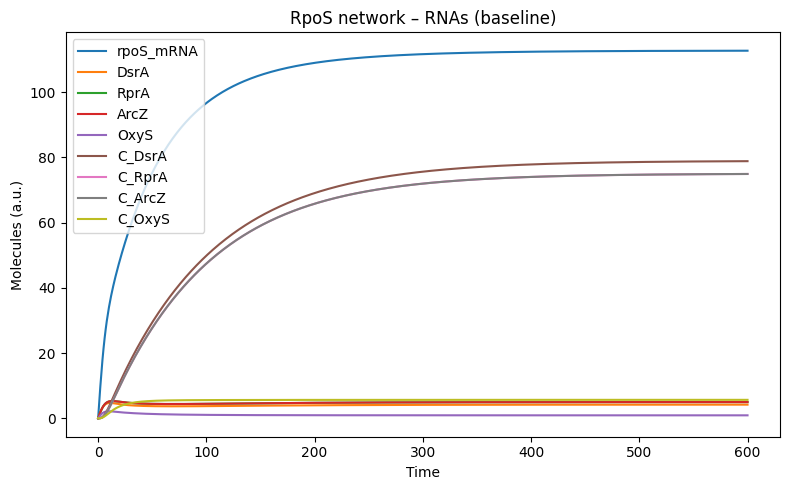

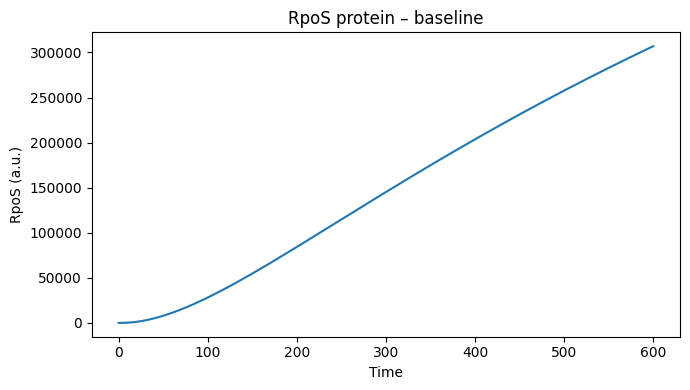

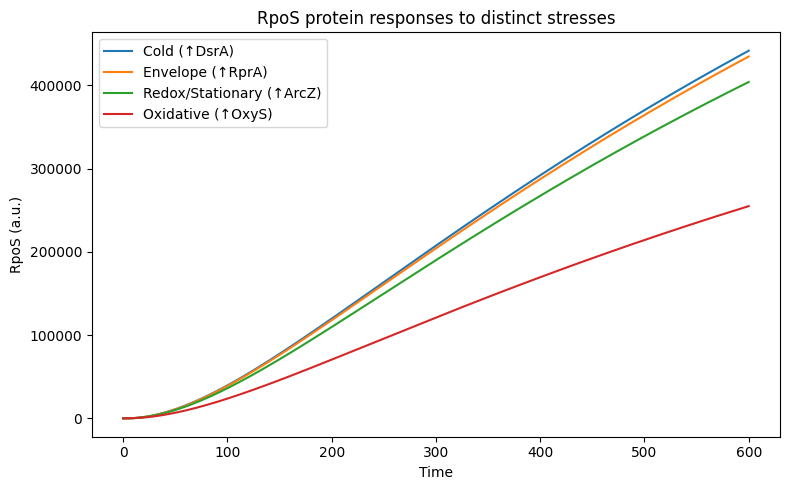

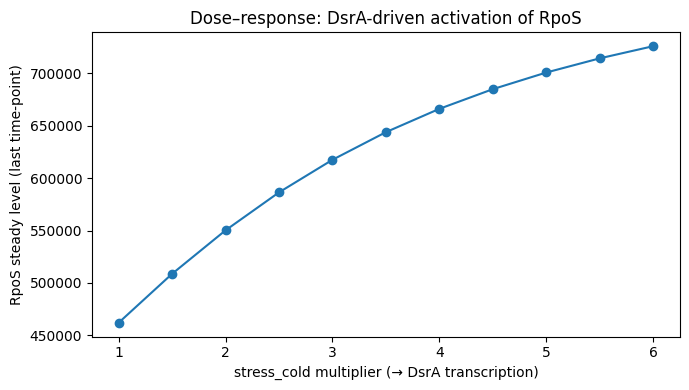

In [3]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# Antimony model
# ==============================
ant = r"""
model RpoS_sRNA_core()

  //----- Compartment
  compartment cell = 1;

  //----- Species (amounts)
  species rpoS_mRNA, RpoS, DsrA, RprA, ArcZ, OxyS;
  species C_DsrA, C_RprA, C_ArcZ, C_OxyS;   // sRNA–mRNA complexes

  //=============================
  // Parameters (tunable)
  //-----------------------------
  k_tx_rpoS   = 5;
  k_tx_DsrA   = 1;     
  k_tx_RprA   = 1;     
  k_tx_ArcZ   = 1;     
  k_tx_OxyS   = 0.5;

  // Stress multipliers
  stress_cold = 1;       
  stress_env  = 1;       
  stress_redx = 1;       
  stress_ox   = 1;       

  // Degradation rates (1/time)
  d_mRNA  = 0.02;        
  d_RpoS  = 0.001;       
  d_sRNA  = 0.05;        

  // Complex-specific degradation
  d_C_act = 0.01;        
  d_C_oxy = 0.08;        

  // Translation rates
  k_tl_base = 0.8;       
  k_tl_act  = 3.0;       

  // Mass-action binding/unbinding
  kon_D = 0.005; koff_D = 0.02;     
  kon_R = 0.004; koff_R = 0.02;     
  kon_A = 0.004; koff_A = 0.02;     
  kon_O = 0.006; koff_O = 0.03;     

  //=============================
  // Reactions
  //-----------------------------
  // Transcription
  J_tx_rpoS:  -> rpoS_mRNA;  k_tx_rpoS;
  J_tx_DsrA:  -> DsrA;       k_tx_DsrA*stress_cold;
  J_tx_RprA:  -> RprA;       k_tx_RprA*stress_env;
  J_tx_ArcZ:  -> ArcZ;       k_tx_ArcZ*stress_redx;
  J_tx_OxyS:  -> OxyS;       k_tx_OxyS*stress_ox;

  // Decay of RNA and protein
  J_deg_mRNA: rpoS_mRNA -> ; d_mRNA * rpoS_mRNA;
  J_deg_DsrA: DsrA      -> ; d_sRNA * DsrA;
  J_deg_RprA: RprA      -> ; d_sRNA * RprA;
  J_deg_ArcZ: ArcZ      -> ; d_sRNA * ArcZ;
  J_deg_OxyS: OxyS      -> ; d_sRNA * OxyS;
  J_deg_RpoS: RpoS      -> ; d_RpoS * RpoS;

  // Binding/unbinding (activators) - Fixed syntax
  J_bind_D: rpoS_mRNA + DsrA -> C_DsrA; kon_D*rpoS_mRNA*DsrA;
  J_unbind_D: C_DsrA -> rpoS_mRNA + DsrA; koff_D*C_DsrA;
  
  J_bind_R: rpoS_mRNA + RprA -> C_RprA; kon_R*rpoS_mRNA*RprA;
  J_unbind_R: C_RprA -> rpoS_mRNA + RprA; koff_R*C_RprA;
  
  J_bind_A: rpoS_mRNA + ArcZ -> C_ArcZ; kon_A*rpoS_mRNA*ArcZ;
  J_unbind_A: C_ArcZ -> rpoS_mRNA + ArcZ; koff_A*C_ArcZ;

  // Binding/unbinding (repressor OxyS)
  J_bind_O: rpoS_mRNA + OxyS -> C_OxyS; kon_O*rpoS_mRNA*OxyS;
  J_unbind_O: C_OxyS -> rpoS_mRNA + OxyS; koff_O*C_OxyS;

  // Complex-specific decay
  J_deg_Cact: C_DsrA -> ; d_C_act*C_DsrA;
  J_deg_Crpr: C_RprA -> ; d_C_act*C_RprA;
  J_deg_Carc: C_ArcZ -> ; d_C_act*C_ArcZ;
  J_deg_Coxy: C_OxyS -> ; d_C_oxy*C_OxyS;

  // Translation
  J_tl_free:  -> RpoS; k_tl_base * rpoS_mRNA;
  J_tl_D:     -> RpoS; k_tl_act  * C_DsrA;
  J_tl_R:     -> RpoS; k_tl_act  * C_RprA;
  J_tl_A:     -> RpoS; k_tl_act  * C_ArcZ;

  //=============================
  // Initial conditions
  rpoS_mRNA = 0;
  RpoS      = 0;
  DsrA      = 0;  
  RprA      = 0;  
  ArcZ      = 0;  
  OxyS      = 0;
  C_DsrA    = 0;  
  C_RprA    = 0;  
  C_ArcZ    = 0;  
  C_OxyS    = 0;

end
"""

# ==============================
# Load model
# ==============================
r = te.loada(ant)
species = r.getFloatingSpeciesIds()
RpoS_idx = species.index('RpoS') + 1

# ==============================
# 1. Baseline
# ==============================
baseline = r.simulate(0, 600, 601)
t = baseline[:, 0]

plt.figure(figsize=(8,5))
for i, sid in enumerate(species):
    if sid != 'RpoS':
        plt.plot(t, baseline[:, i+1], label=sid)
plt.xlabel("Time"); plt.ylabel("Molecules (a.u.)")
plt.title("RpoS network – RNAs (baseline)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(t, baseline[:, RpoS_idx])
plt.xlabel("Time"); plt.ylabel("RpoS (a.u.)")
plt.title("RpoS protein – baseline")
plt.tight_layout(); plt.show()

# ==============================
# 2. Stress Scenarios
# ==============================
def simulate_stress(label, **stress):
    r.resetAll()
    for k, v in stress.items():
        r[k] = v
    out = r.simulate(0, 600, 601)
    return label, out

scenarios = [
    simulate_stress("Cold (↑DsrA)", stress_cold=4),
    simulate_stress("Envelope (↑RprA)", stress_env=4),
    simulate_stress("Redox/Stationary (↑ArcZ)", stress_redx=3),
    simulate_stress("Oxidative (↑OxyS)", stress_ox=4),
]

plt.figure(figsize=(8,5))
for label, mat in scenarios:
    plt.plot(mat[:,0], mat[:,RpoS_idx], label=label)
plt.xlabel("Time"); plt.ylabel("RpoS (a.u.)")
plt.title("RpoS protein responses to distinct stresses")
plt.legend(); plt.tight_layout(); plt.show()

# ==============================
# 3. Parameter Scan (DsrA stress multiplier)
# ==============================
r.resetAll()
scan = np.linspace(1, 6, 11)
steady = []
for s in scan:
    r.resetAll()
    r['stress_cold'] = s
    mat = r.simulate(0, 1000, 1001)
    steady.append(mat[-1, RpoS_idx])

plt.figure(figsize=(7,4))
plt.plot(scan, steady, marker='o')
plt.xlabel("stress_cold multiplier (→ DsrA transcription)")
plt.ylabel("RpoS steady level (last time-point)")
plt.title("Dose–response: DsrA-driven activation of RpoS")
plt.tight_layout(); plt.show()


In [4]:
baseline

    time, [rpoS_mRNA],  [RpoS],   [DsrA],   [RprA],   [ArcZ],   [OxyS],   [C_DsrA],   [C_RprA],   [C_ArcZ],   [C_OxyS]
 [[    0,           0,       0,        0,        0,        0,        0,          0,          0,          0,          0],
  [    1,     4.92482, 1.99666, 0.967498, 0.969075, 0.969075, 0.482974, 0.00799303, 0.00640069, 0.00640069, 0.00469652],
  [    2,      9.6102, 8.05185,  1.84404,   1.8557,   1.8557, 0.916396,  0.0604232,  0.0485227,  0.0485227,  0.0347023],
  [    3,     13.9541, 18.4129,  2.60143,  2.63708,  2.63708,   1.2839,   0.190185,   0.153406,   0.153406,   0.106562],
  [    4,     17.9003, 33.4707,  3.22658,  3.30179,  3.30179,  1.57867,   0.415827,   0.337348,   0.337348,   0.226909],
  [    5,     21.4344, 53.6902,  3.71989,  3.84869,  3.84869,  1.80217,   0.742617,   0.606556,   0.606556,   0.394049],
  [    6,      24.574, 79.5493,  4.09161,  4.28446,  4.28446,  1.96163,    1.16566,   0.959246,   0.959246,   0.600695],
  [    7,     27.3571, 111.495,  4